<a href="https://colab.research.google.com/github/microprediction/winning/blob/main/Sepal_Width.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install winning
!pip install pandas
!pip install scipy
!pip install nevergrad
from winning.skew_calibration import skew_dividend_implied_ability, skew_ability_implied_dividends
import numpy as np
import pylab
import scipy.stats as stats
import pandas as pd
from winning.skew_calibration import skew_dividend_implied_ability, skew_ability_implied_dividends, state_price_implied_ability
import numpy as np
import pylab
from winning.lattice import center_density, skew_normal_density
from winning.lattice_conventions import ALT_UNIT, ALT_L, ALT_SCALE, ALT_A
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from scipy.stats import norm
import math



# Some empirical ability transforms - just for fun
This notebook explores the so-called horse race transform (aka 'ability transform') applied to measured quantities or counts. For instance, if we have n different things that are being counted, then we can think of the proportions as winning probabilities p_i. We then infer location paramters a_i that would result in the same winning probabilities if the performance is modeled as skew-normal. The map from the set of p_i to the set of a_i is called the horse race transform. You can read more about its motivations in the [paper](https://github.com/microprediction/winning/blob/main/docs/Horse_Race_Problem__SIAM_updated.pdf).

If you have a list of labels (e.g. a vector like [1,1,3,2,2,5,1] listing the "winner" of a race) then you need only pass this into ability_plot to see whether the implied abilities are normally distributed, or not. Of course, some other generative model might be plausible.

In [ ]:

def normalize(x):
  x_sum = np.sum(x)
  return [xi/x_sum for xi in x]

def standardize(x):
    xc = [xi-np.mean(x) for xi in x]
    xs = [xci/np.std(xc) for xci in xc ]
    return xs

def ability_transform(x,a,cull=1):
    sx = list(reversed(sorted(x)))
    nzx = [ x_ for x_ in sx if x_>0 ][cull:-cull]  # Chop highest and lowest
    z = normalize(nzx)
    zt = [ max(zi,0.00000000005) for zi in z] # Instability - need to look into this or increase lattice
    density = skew_normal_density(L=2*ALT_L, unit=ALT_UNIT, loc=0., scale=ALT_SCALE, a=a)
    ability = state_price_implied_ability(prices=zt, density=density)
    return standardize(ability)

def proximity(x,a):
    sa = ability_transform(x,a)
    cdfs = [ stats.norm.cdf(sai) for sai in sa ]
    n = len(cdfs)
    std_cdfs = np.linspace(1/(n+1),1-1/(n+1),n)
    return np.mean([ abs(c1-c2) for c1,c2 in zip(sorted(cdfs),std_cdfs)])

def ability_fit(x):
    """
       Finds the skew best matching the distribution
    """
    def objective(a):
      return proximity(x,a)

    result = minimize(objective, x0=[0], bounds=[(-3,3)],options={'maxiter':100})
    best_a = result.x.tolist()[0]

    return best_a

def ability_plot(x,a=0.0,cull=1,title=None):
   y = ability_transform(x,a,cull=1)
   f = stats.probplot(y, dist="norm", plot=pylab)
   if title is None:
     plt.title('a='+str(a))
   else:
     plt.title(title)
   pylab.show()
   return f

def ability_hist(x,a=0.0,cull=1,title=None):
   y = ability_transform(x,a,cull=1)
   plt.hist(y,bins=50)
   if title is None:
     plt.title('a='+str(a))
   else:
     plt.title(title)

def ability_log_hist(x,a=0.0,cull=1,title=None):
   y = ability_transform(x,a,cull=1)
   y_min = np.min(y)
   y_shift = [yi+y_min+1.0 for yi in y]
   plt.hist(y_shift,bins=50)
   if title is None:
     plt.title('a='+str(a))
   else:
     plt.title(title)

def neg_ability_log_hist(x,a=0.0,cull=1,title=None,offset=1.0):
   y = ability_transform(x,a,cull=1)
   y_max = np.max(y)
   y_shift = [y_max-yi+offset for yi in y]
   plt.hist(y_shift,bins=50)
   if title is None:
     plt.title('a='+str(a))
   else:
     plt.title(title)

def log_hist(x,a=0.0,cull=1,title=None):
   y = ability_transform(x,a,cull=1)
   plt.hist(y,bins=50)
   if title is None:
     plt.title('a='+str(a))
   else:
     plt.title(title)

def log_norm_hist(x,a=0.0,cull=1,title=None,offset=1.0):
   x_min = np.min(x)
   x_shift = [xi-x_min+offset for xi in x]
   log_x = [math.log(xsi) for xsi in x_shift]
   plt.hist(log_x,bins=50)
   if title is None:
     plt.title('log normal')
   else:
     plt.title(title)

def log_norm_plot(x,a=0.0,cull=1,title=None,offset=1.0):
   x_min = np.min(x)
   x_shift = [xi-x_min+offset for xi in x]
   log_x = [-math.log(xsi) for xsi in x_shift]
   f = stats.probplot(log_x, dist="norm", plot=pylab)
   if title is None:
     plt.title('log normal')
   else:
     plt.title(title)
   pylab.show()

def manual_search(x):
   ajs = list(np.linspace(-4,4,50))
   prox = [proximity(x,aj) for aj in ajs ]
   plt.plot(ajs,prox)


# Tests for power law versus lognormal

In [ ]:
!pip install powerlaw
from pprint import pprint
import powerlaw

In [ ]:
def compare(data):
  """ test power law versus lognormal"""
  results = powerlaw.Fit(data)
  R, p = results.distribution_compare('power_law', 'lognormal')
  pprint({'R':R,'p':p})

# Market cap

Let's take a quick look at market capitalization in the sp500.

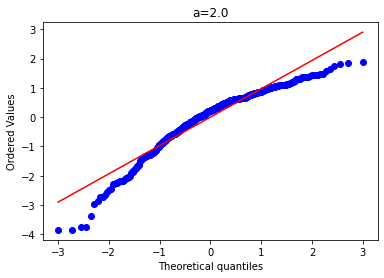

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/datasets/s-and-p-500-companies-financials/master/data/constituents-financials.csv')
_ = ability_plot(df['Market Cap'].values,a=2.0)

Nope that ain't normal. So then, what does the distribution of "ability to compete" look like actually?

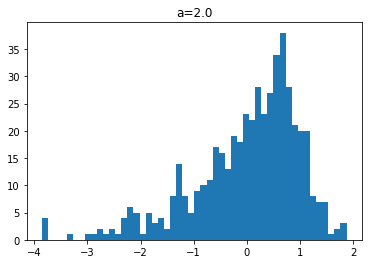

In [ ]:
_ = ability_hist(df['Market Cap'].values,a=2.0)

Maybe a reasonable generative model is skew-normal ability (not just skew-normal performance).

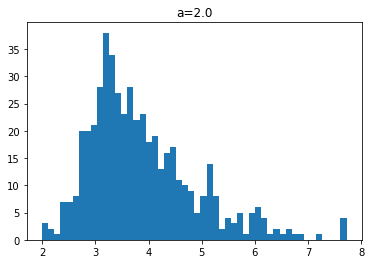

In [ ]:
_ = neg_ability_log_hist(df['Market Cap'].values,a=2.0,offset=2)

I think the truncation makes this awkward

In [ ]:
compare(df['Market Cap'].values)

Calculating best minimal value for power law fit
/usr/local/lib/python3.7/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


{'R': -3.3767561279617695, 'p': 0.09539227833926825}


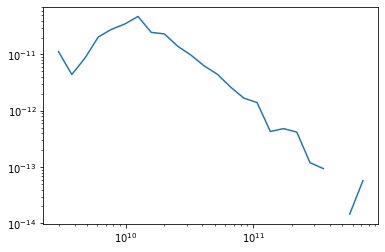

In [ ]:
powerlaw.plot_pdf(df['Market Cap'].values)

# Snooker prizemoney
...and not a great model for snooker prizemoney either!

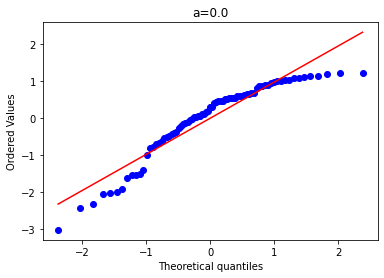

In [ ]:
snooker = pd.read_csv('https://raw.githubusercontent.com/rafaluk/snooker_prizes/master/snooker_data.csv',sep=';')
vals=snooker['Money_Prizes'].values
_ = ability_plot(vals,a=0.)

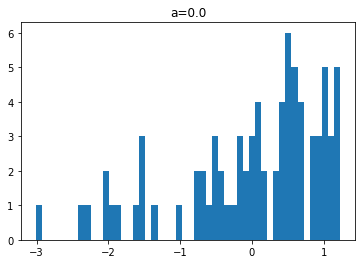

In [ ]:
_ = ability_hist(vals,a=0.0)

Again, we have truncation perhaps  caused by league cutoff. This one actually looks like a power law...

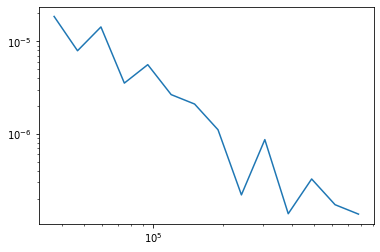

In [ ]:
powerlaw.plot_pdf(vals)

# Power Law

Incidentally, things generateed by power laws aren't "the same". First, a look at transforming scores.

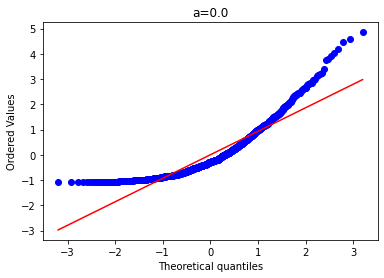

In [ ]:
r = stats.powerlaw.rvs(a=1.66, size=1000)
_ = ability_plot(r,0.0)

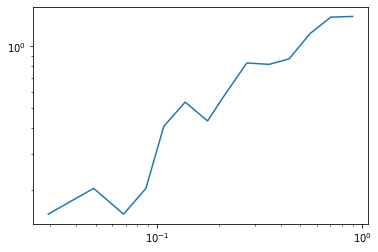

In [ ]:
powerlaw.plot_pdf(r)

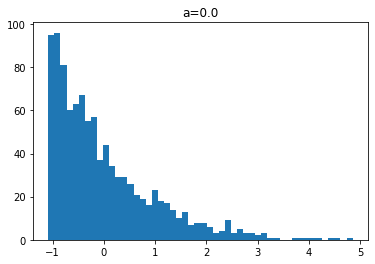

In [ ]:
_ = ability_hist(r,0.0)

In [ ]:
compare(r)

Calculating best minimal value for power law fit
/usr/local/lib/python3.7/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


{'R': -32.23657065706207, 'p': 3.6038577051723125e-06}


# The left tail
A better way to come at this hints at the connection to EV's and the first order statistic, which has limit as an extreme value distribution. Note the fit to one part of the distribution when we generate exponenial frequencies.

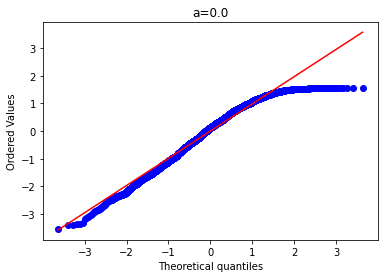

In [ ]:
x = stats.expon.rvs(0.5,size=5000)
_ = ability_plot(x,0.0)

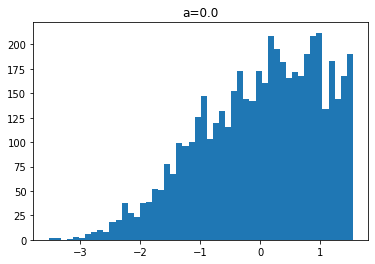

In [ ]:
_ = ability_hist(x,0.0)

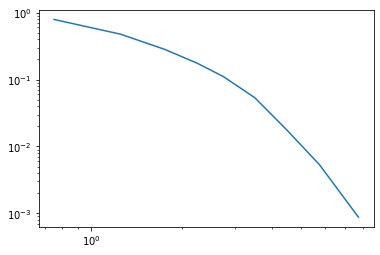

In [ ]:
powerlaw.plot_pdf(x)

In [ ]:
compare(x)

Calculating best minimal value for power law fit
/usr/local/lib/python3.7/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


{'R': -8.220712825877513, 'p': 0.013877644961982584}


# The Right Tail
Suppose the first order statistic becomes concentrated. Then what matters as we move in to the right tail (i.e. the poor performers)?

It ain't normal...


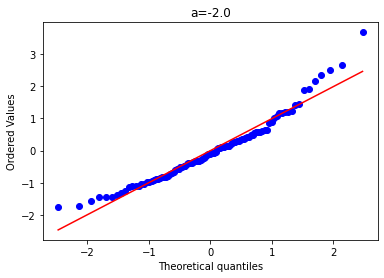

In [ ]:
a = -2.0 # skew paramter, mess with it
nrvx = stats.norm.rvs(size=200)
_ = ability_plot(nrvx,a=a)

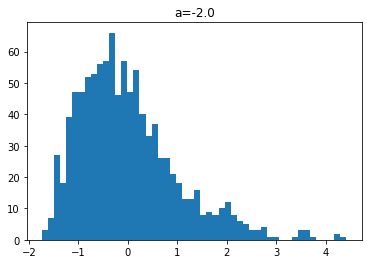

In [ ]:
_ = ability_hist(nrvx,a=a)

###  Log-normal variables - the limit n->infinity
But not take a look at this...

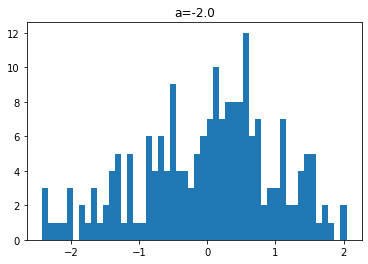

In [ ]:
nrvx = stats.norm.rvs(size=200)
_ = ability_hist([math.exp(xi) for xi in nrvx],a=a)

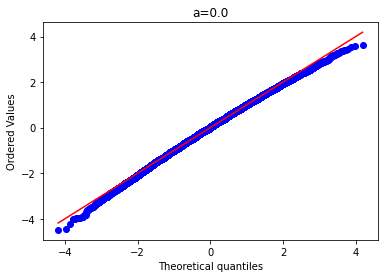

In [ ]:
nrvx = stats.norm.rvs(size=50000)
z = [math.exp(xi) for xi in nrvx]
_ = ability_plot(z,0.0)

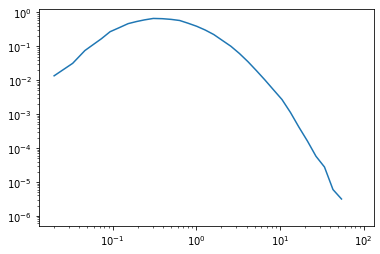

In [ ]:
powerlaw.plot_pdf(z)

In [ ]:
compare(z)

Calculating best minimal value for power law fit
/usr/local/lib/python3.7/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


{'R': -1.020006492412556, 'p': 0.36060316190576835}


# Athletic prizemoney

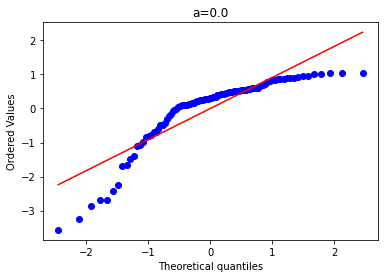

In [ ]:
athletes = pd.read_csv('https://raw.githubusercontent.com/ali-ce/datasets/master/Most-paid-athletes/Athletes.csv')
_ = ability_plot(athletes['Total Pay'].replace('[\$,]', '', regex=True).astype(float),a=0.0)

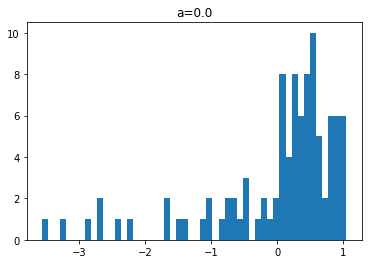

In [ ]:
_ = ability_hist(athletes['Total Pay'].replace('[\$,]', '', regex=True).astype(float),a=0.0)

A little surprising, but the right tail is missing (i.e. you and me)

# Global covid cases

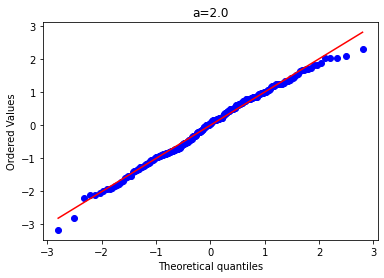

In [ ]:
covid = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
covid_cases = covid[covid.columns[-1]].values
_ = ability_plot(covid_cases,a=2.0)

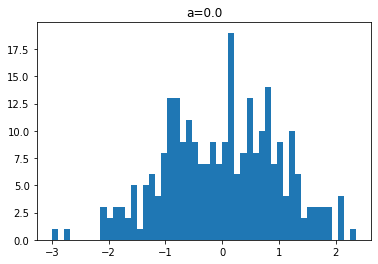

In [ ]:
_ = ability_hist(covid_cases)

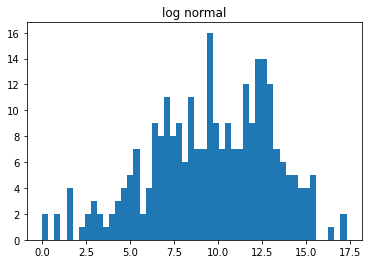

In [ ]:
_ = log_norm_hist(vals,offset=1,cull=50)

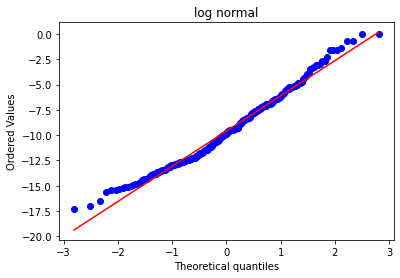

In [ ]:
_ = log_norm_plot(covid_cases)

# U.S. Covid by county

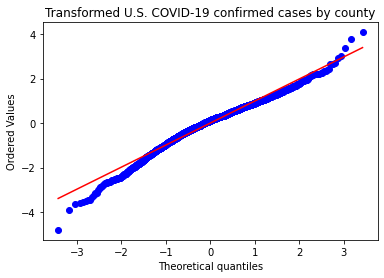

((array([-3.41945459, -3.1702531 , -3.03213577, ...,  3.03213577,
          3.1702531 ,  3.41945459]),
  array([-4.8003504 , -3.89619976, -3.62350308, ...,  3.35102311,
          3.77538954,  4.07764824])),
 (0.9906947200979668, -2.044244849922744e-16, 0.989325852739638))

In [ ]:
counties = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/live/us-counties.csv')
ccases = [ c for c in sorted(counties['confirmed_cases'].values) if c>0 ]
ability_plot(ccases,a=0.0,title='Transformed U.S. COVID-19 confirmed cases by county')


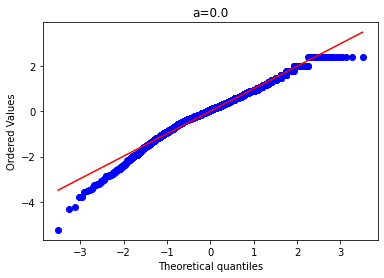

((array([-3.51125824, -3.26814139, -3.13373139, ...,  3.13373139,
          3.26814139,  3.51125824]),
  array([-5.23869854, -4.32330379, -4.24358035, ...,  2.38119832,
          2.38119832,  2.38119832])),
 (0.9918815492200136, 5.939259950934616e-19, 0.990869696455742))

In [ ]:
sdeaths = sorted(counties['deaths'].values)
dths = [ d for d in sdeaths if d>0]
_ = ability_plot(dths,a=0.0)

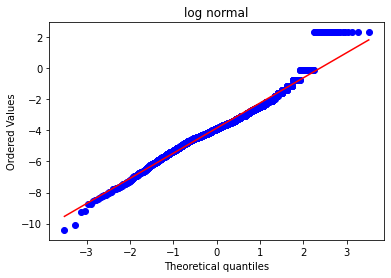

In [ ]:
_ = log_norm_plot(dths,offset=0.1)

In [ ]:
county_density = pd.read_csv('https://raw.githubusercontent.com/camillol/cs424p3/master/data/Population-Density%20By%20County.csv')
sdensity = sorted(county_density['Density per square mile of land area'])
ability_plot(sdensity,a=0.0)


# City sizes

In [ ]:
city_sizes = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/us-cities-top-1k.csv')

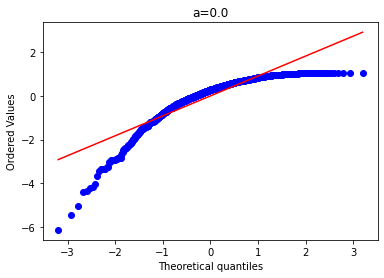

In [ ]:
_ = ability_plot(city_sizes['Population'])
# Better fit by power law?

# Different COVID data from paper
.... that says its a power law

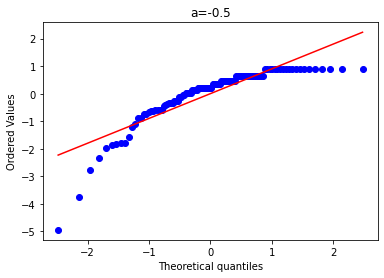

In [ ]:
covid_from_power_law = pd.read_csv('https://raw.githubusercontent.com/berndblasius/Covid19/master/data/time_series_19-covid-Deaths.csv')
sv = [ v for v in covid_from_power_law[covid_from_power_law.columns[-1]].values if v>1]
ability_plot(sv,-0.5)

# GDP / capita

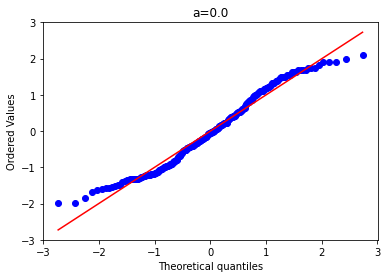

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/curran/data/gh-pages/worldFactbook/GDPPerCapita.csv')
vals = df['GDP Per Capita']
ability_plot(vals,a=0.0)

# Laptops per country

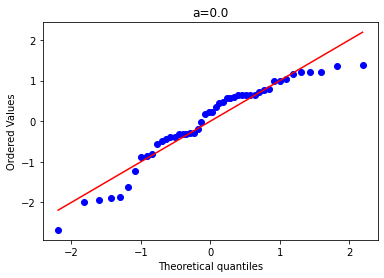

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/curran/data/gh-pages/olpc/laptopsPerCountry.csv')
vals = df['count']
ability_plot(vals,a=0.0)

In [ ]:
# Linchings by state

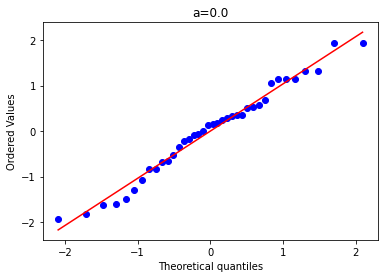

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/curran/data/gh-pages/tuskegeeInstitute/lynchings-1882-1968-by-state-and-race.csv')
ability_plot(df['Total'])

# Migrants

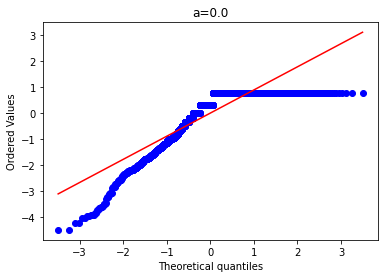

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/curran/data/gh-pages/migrants/events.csv')
ability_plot(df['dead_and_missing'])

# Weed prices

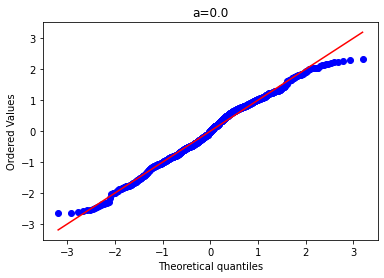

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/curran/data/gh-pages/amitkaps/weed/Weed_Price.csv')
ability_plot(df['HighQN'][:1000],a=0.0)

# State populations

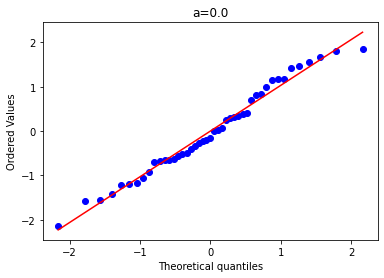

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/curran/data/gh-pages/amitkaps/weed/Population_State.csv')
ability_plot(df['value'],a=0.0)

# Syrian violations

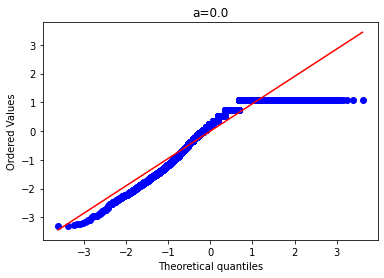

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/curran/data/gh-pages/SyriaViolationsDocumentationCenter/dataAggregated.csv')
ability_plot(df['count'],a=0.0)

# Mortality causes

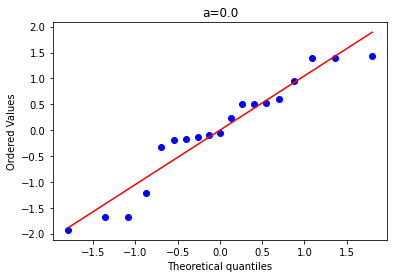

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/curran/data/gh-pages/all/cdc_mortality_mortality_underyling_cause_by_years_simplified.csv')
ability_plot(df['1998'],a=0.0)

# Infant mortality

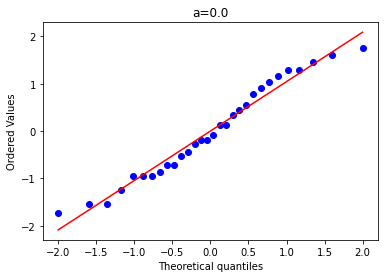

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/curran/data/gh-pages/all/data.gov.in_infantMortalityRate_Infant_Mortality_Rate_1.csv')
ability_plot(df['2011'],a=0.0)

# Petals

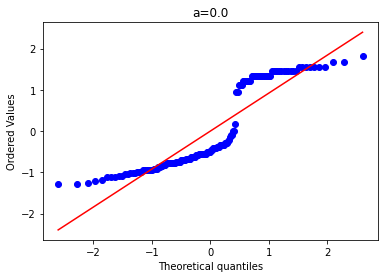

In [ ]:
df= pd.read_csv('https://raw.githubusercontent.com/curran/data/gh-pages/all/iris_iris.csv')
_ = ability_plot(df['Petal Length'],a=0.0)

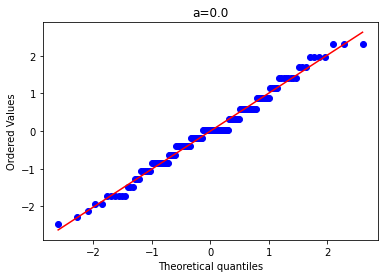

In [ ]:
_ = ability_plot(df['Sepal Width'],a=0.0)

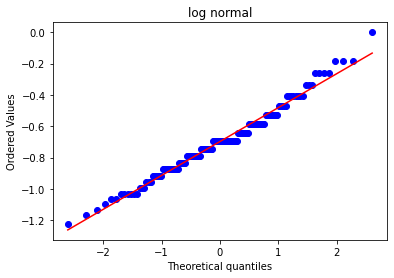

In [ ]:
_ = log_norm_plot(df['Sepal Width'])

# More city populations

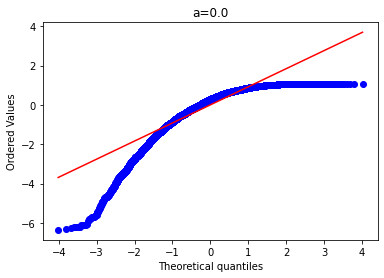

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/curran/data/gh-pages/all/geonames_cities15000.csv')
ability_plot(df['population'],a=0.0)

# browser market share

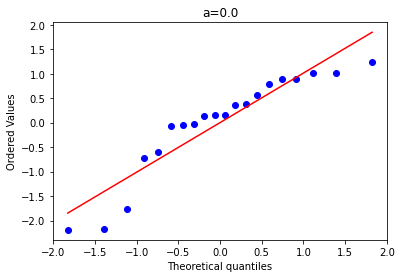

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/curran/data/gh-pages/all/statCounter_currentBrowserMarketShares.csv')
_ = ability_plot(df['marketShare'],a=0.0)

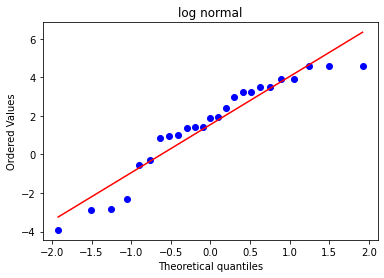

In [ ]:
_ = log_norm_plot(df['marketShare'],offset=0.01)

# Earthquake magnitudes

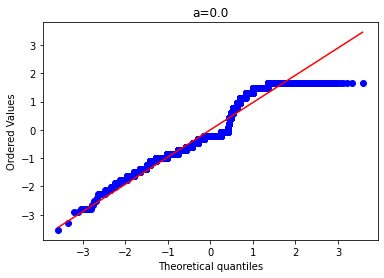

((array([-3.57763519, -3.33873965, -3.20688667, ...,  3.20688667,
          3.33873965,  3.57763519]),
  array([-3.53888144, -3.30877569, -2.92097658, ...,  1.67029078,
          1.67029078,  1.67029078])),
 (0.9639716034191449, -3.3508412351341826e-16, 0.963186045698202))

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/curran/data/gh-pages/all/usgs_centennial_earthquakes.csv')
ability_plot(df['magnitude'][:4000],a=0.0)

#Prices

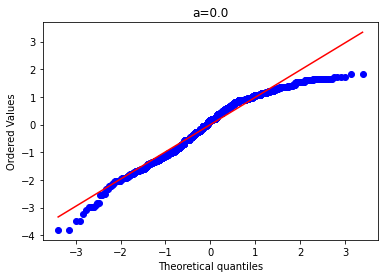

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/curran/data/gh-pages/all/superstoreSales_superstoreSales.csv')
ability_plot(df['Unit Price'][:2000],a=0.)

# Christians by country

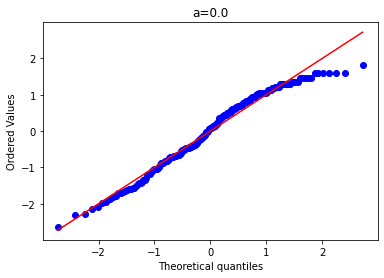

((array([-2.72308553, -2.41587324, -2.24097944, -2.11585328, -2.01707996,
         -1.93478202, -1.86382039, -1.80116541, -1.74487463, -1.69362494,
         -1.64647279, -1.60272067, -1.56183774, -1.52341024, -1.48710916,
         -1.45266833, -1.41986927, -1.3885303 , -1.35849866, -1.32964462,
         -1.30185701, -1.27503981, -1.24910948, -1.22399288, -1.19962556,
         -1.17595045, -1.15291675, -1.13047901, -1.10859643, -1.08723221,
         -1.06635304, -1.04592868, -1.02593156, -1.0063365 , -0.98712042,
         -0.9682621 , -0.94974199, -0.93154204, -0.91364553, -0.89603698,
         -0.87870196, -0.86162706, -0.84479974, -0.82820831, -0.81184179,
         -0.7956899 , -0.77974297, -0.76399191, -0.74842816, -0.73304362,
         -0.71783066, -0.70278204, -0.68789093, -0.67315081, -0.65855552,
         -0.64409919, -0.62977624, -0.61558133, -0.60150939, -0.58755557,
         -0.57371523, -0.55998393, -0.54635741, -0.53283159, -0.51940256,
         -0.50606656, -0.49281996, -0.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/curran/data/gh-pages/pew/religion/religionByCountry.csv')
_ = ability_plot([float(v) for v in df['Christian'] if not '<' in v],a=0.0)

# Startups

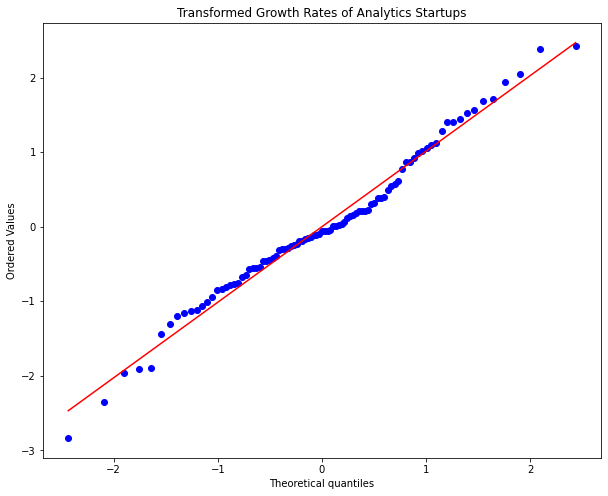

100

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/curran/data/gh-pages/mattermark/2015-top-100-analytics-startups.csv')
plt.figure(figsize=(10,8))
ability_plot(df['Growth Score'],a=0.,title='Transformed Growth Rates of Analytics Startups')
len(df)

# Big data revenue

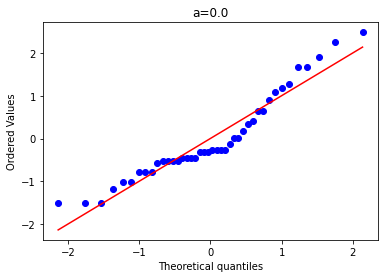

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/curran/data/gh-pages/wikibon/revenueBigData2012.csv')
ability_plot(df['% Big Data Software Revenue'],a=0.0)

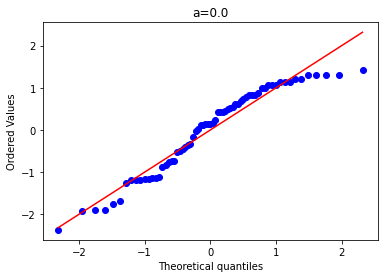

In [ ]:
ability_plot(df['Big Data Revenue'],a=0.0)

# War deaths

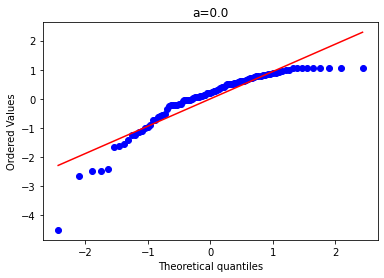

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/curran/data/gh-pages/correlatesofwar/wars.csv')
ability_plot(df['batDeath'],a=0.0)

# Flu

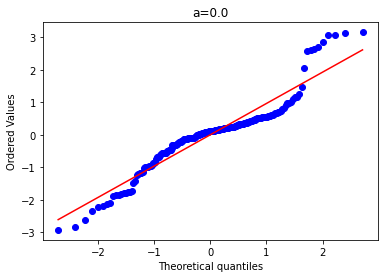

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/curran/data/gh-pages/usda/avian_influenza/avian_flu_cleaned.csv')
ability_plot(df['Size'],a=0.0)

# Cars

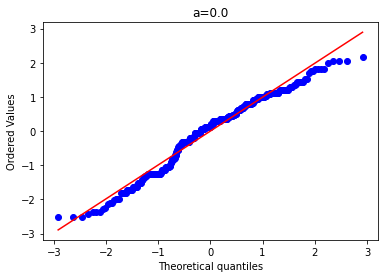

In [ ]:
df= pd.read_csv('https://raw.githubusercontent.com/curran/data/gh-pages/uci_ml/auto-mpg/auto-mpg.csv')
ability_plot(df['horsepower'],a=0.0)

# Abalone

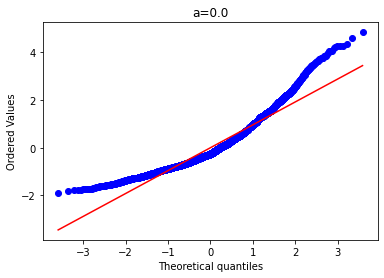

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/curran/data/gh-pages/uci_ml/abalone/abalone.csv')
ability_plot(df['whole_weight'],a=0.0)

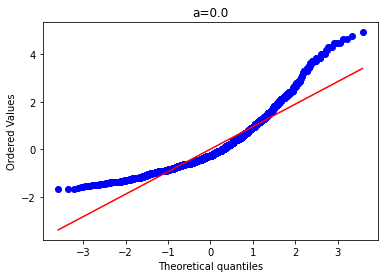

In [ ]:
ability_plot(df['diameter'],a=0.0)

# Synomyns


In [ ]:
!pip install PyDictionary
!pip install wordfreq

In [ ]:
from PyDictionary import PyDictionary
from wordfreq import word_frequency
dictionary = PyDictionary()

def synonym_plot(wd='mother',a=0.0):
  """  Ability plot of synomyns for any word
  """
  wd_synonyms = dictionary.synonym(wd)
  freqs = [ word_frequency(w,'en') for w in wd_synonyms]
  ability_plot(freqs,a=a,cull=0)

def synonym_logplot(wd='mother',offset=1.0):
  wd_synonyms = dictionary.synonym(wd)
  freqs = [ word_frequency(w,'en') for w in wd_synonyms]
  log_norm_plot(freqs,offset=offset)

def synonym_hist(wd='mother',a=0.0):
  """  Ability plot of synomyns for any word
  """
  wd_synonyms = dictionary.synonym(wd)
  freqs = [ word_frequency(w,'en') for w in wd_synonyms]
  ability_hist(freqs,a=a,cull=0)

def synonym_loghist(wd='mother',offset=0.1):
  """  Ability plot of synomyns for any word
  """
  wd_synonyms = dictionary.synonym(wd)
  freqs = [ word_frequency(w,'en') for w in wd_synonyms]
  log_norm_hist(freqs,offset=offset)


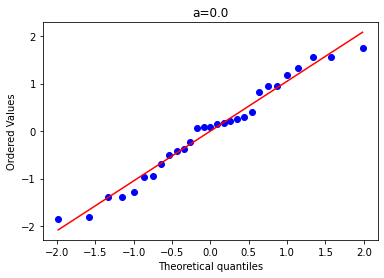

In [ ]:
synonym_plot('beautiful')

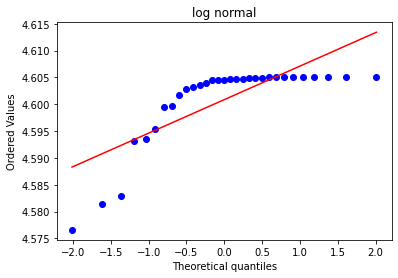

In [ ]:
synonym_logplot('beautiful',offset=0.01)

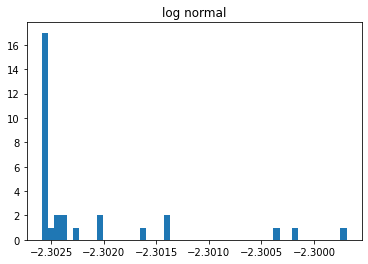

In [ ]:
_ = synonym_loghist('beautiful',offset=0.1)

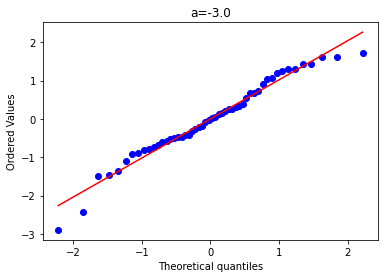

In [ ]:
synonym_plot('bright',a=-3.0)

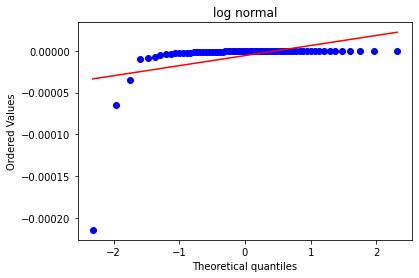

In [ ]:
synonym_logplot('bright',offset=1)

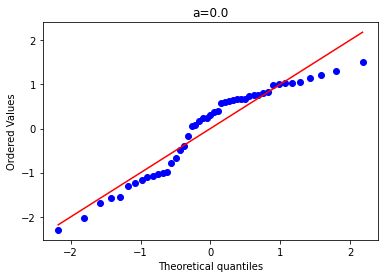

In [ ]:
synonym_plot('bad',a=0.0)

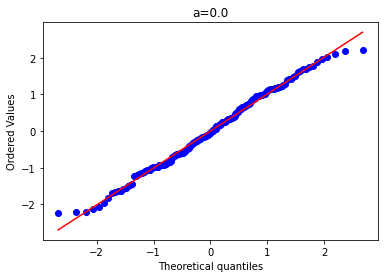

In [ ]:
synonym_plot('move',a=0.0)

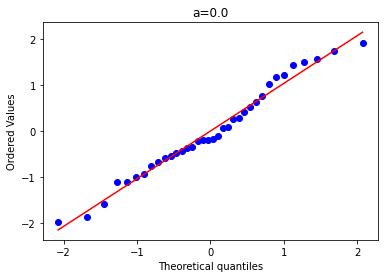

In [ ]:
synonym_plot('say',a=0.0)

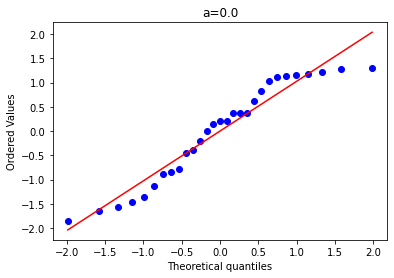

In [ ]:
synonym_plot('look',a=0.0)

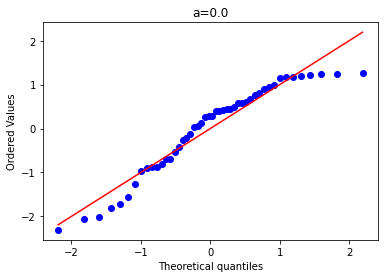

In [ ]:
synonym_plot('little',a=0.0)

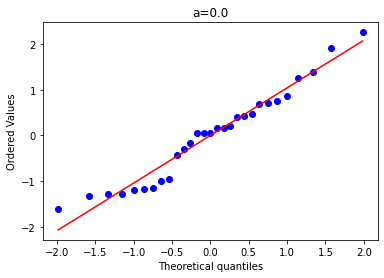

In [ ]:
synonym_plot('fear',a=0.0)

In [ ]:
# Surname frequencies

In [ ]:
def category_plot(category='cities',sub='united_states'):
  df = pd.read_csv('https://raw.githubusercontent.com/imsky/wordlists/master/names/CATEGORY/SUB.txt'.replace('CATEGORY',category).replace('SUB',sub))
  freqs = [ word_frequency(w,'en') for w in df[df.columns[0]].values ]
  ability_plot(freqs,cull=0)


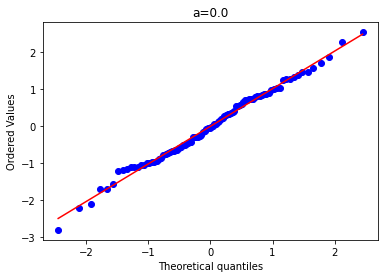

In [ ]:
category_plot('cities','united_states')

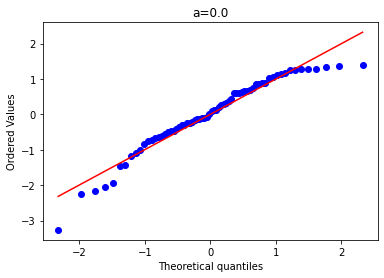

In [ ]:
category_plot('cities','france')

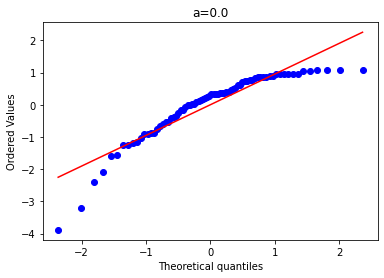

In [ ]:
category_plot('cities','netherlands')

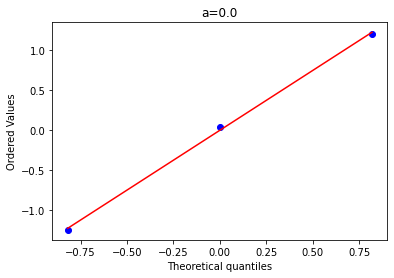

In [ ]:
category_plot('cities','canada')

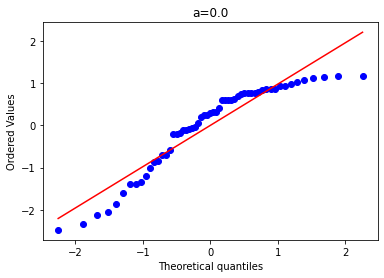

In [ ]:
category_plot('cities','switzerland')

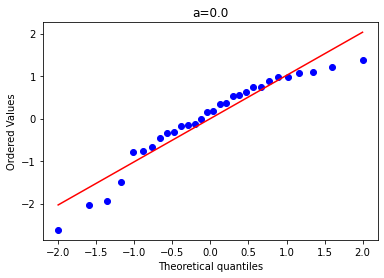

In [ ]:
category_plot('codenames','intel')

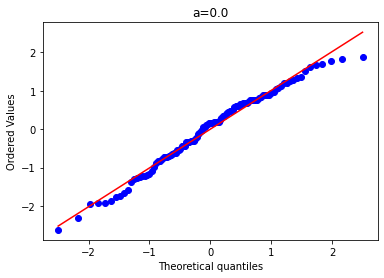

In [ ]:
category_plot('codenames','apple')

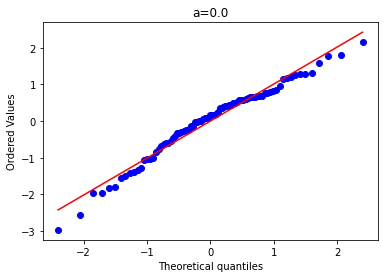

In [ ]:
category_plot('codenames','microsoft')

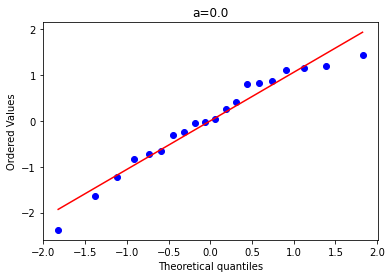

In [ ]:
category_plot('companies','unicorns')

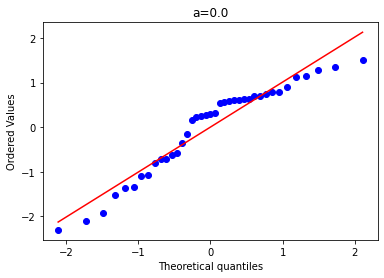

In [ ]:
category_plot('people','computing')

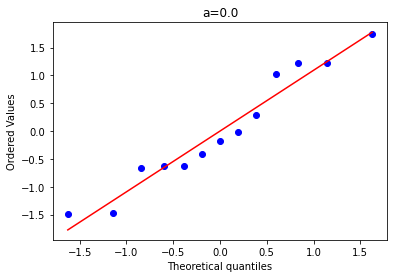

In [ ]:
category_plot('people','butlers')

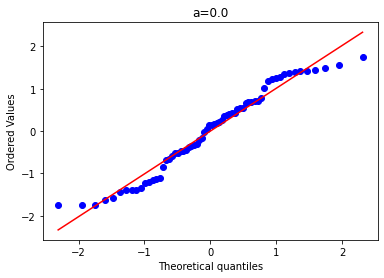

In [ ]:
category_plot('streets','newyork')

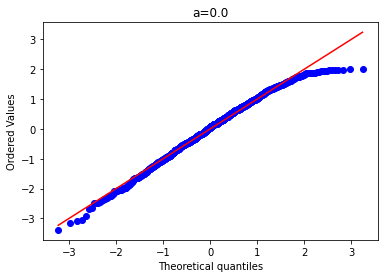

In [ ]:
category_plot('streets','chicago')

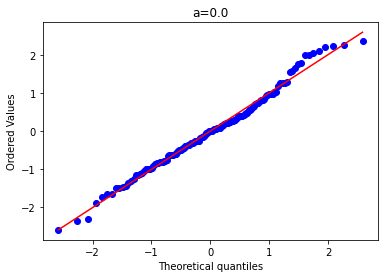

In [ ]:
category_plot('surnames','irish')

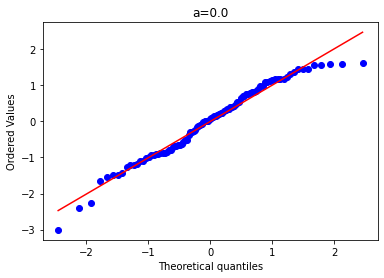

In [ ]:
category_plot('surnames','italian')

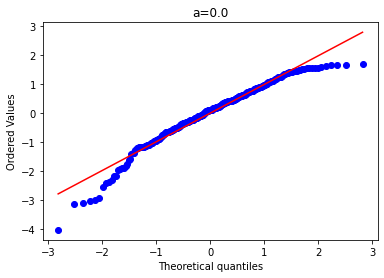

In [ ]:
category_plot('surnames','german')

# Trump votes

In [ ]:
!pip install benfordslaw

[benfordslaw] >Import dataset [USA]


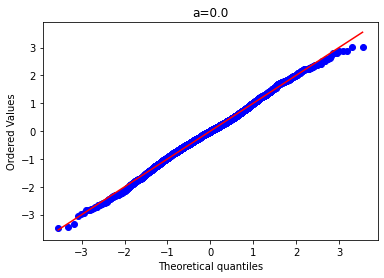

In [ ]:
from benfordslaw import benfordslaw
bl = benfordslaw(alpha=0.05)
df = bl.import_example(data='USA')
X = df['votes'].loc[df['candidate']=='Donald Trump'].values
_ = ability_plot(X,a=0.0)

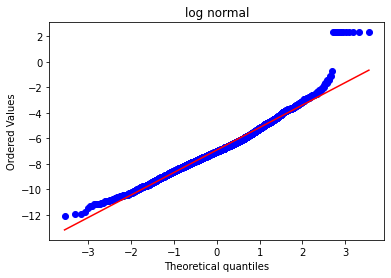

In [ ]:
_ = log_norm_plot(X,offset=0.1)

@misc{erdogant2020benfordslaw,
  title={benfordslaw},
  author={Erdogan Taskesen},
  year={2019},
  howpublished={\url{https://github.com/erdogant/benfordslaw}},
}

# Tweets

# References etc



https://statweb.stanford.edu/~owen/courses/306a/ZipfByHera.pdf
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4176592/figure/F1/


https://www.sciencedirect.com/science/article/pii/S0378437119302079






